In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import time
import timeit
import warnings
warnings.filterwarnings('ignore')
global_params = {
    'text.usetex' : False,
    'font.family' : 'serif',
    'font.sans-serif' : ['Helvetica'],
    'ps.usedistiller' : 'xpdf',
    'ps.distiller.res' : 3000,
    'axes.labelsize' : 13,
          #'text.fontsize' : 16,
    'legend.fontsize' : 10,
    'xtick.labelsize' : 12,
    'ytick.labelsize' : 12,
    'axes.linewidth': 2.0,
    'axes.grid':True,  
    'figure.figsize' : [7,5],
    'grid.linestyle':'--',
    'grid.color':'k',
    'grid.alpha':0.2}
pylab.rcParams.update(global_params)
#use env ../speedPy.yml
rng = np.random.default_rng()

## Doing Math By Hand Is Important
In this notebook I will show with an example why doing math by hand is important for making your code go fast
### Example
For this example we will be drawing from a multivariate normal with many dimensions. Our covariance matrix has a specific form which we will be exploiting for speed ups later.

Our covariance matrix looks like
$$
\sigma=
\begin{bmatrix} 
a_{0} & 0     & \cdots & 0      & c_{0}  & 0     &\cdots &0     \\
0     & a_{1} & \ddots &        & \ddots & c_{1} & \ddots&\vdots\\
\vdots&\ddots & \ddots & \ddots &        &\ddots &\ddots &\vdots\\
0     &       &  \ddots& a_{n}  &  \ddots&       &\ddots & c_{n}\\
c_{0} & 0     &\cdots &0        &b_{0}   & 0     & \cdots& 0    \\   
0     & c_{1} & \ddots &        & \ddots & b_{1} & \ddots&\vdots\\
\vdots&\ddots & \ddots & \ddots &        &\ddots &\ddots &\vdots\\
0     &\cdots &  0     & c_{n}  &  0     & \cdots&0      & b_{n}\\

\end{bmatrix}
$$
or more clearly

$$
\sigma=\begin{bmatrix}
A & C\\
C & B
\end{bmatrix}
$$
where $A,B$ and $C$ are $nxn$ diagnal matricies with elements $A_{ii}=a_i$ and so on.

We have our problem so now we construct our matrix and draw from it.

In [9]:
def large_cov_mvn(a,b,c,seed=42,method='svd'):
    rng = np.random.default_rng(seed=seed)
    #draw a sample using a large cov matrix
    dim=2*len(a)
    #first construct the matrix
    cov=np.zeros((dim,dim))
    for i in range(len(a)):
        cov[i][i]=a[i]
        cov[i+dim//2][i+dim//2]=b[i]
        cov[i+dim//2][i]=c[i]
        cov[i][i+dim//2]=c[i]
    return rng.multivariate_normal(mean=np.zeros(dim),cov=cov,method=method)
n=10
a=rng.uniform(.1,10,n)
b=rng.uniform(.1,10,n)
c=rng.uniform(.1,10,n)
large_cov_mvn(a,b,c)

array([ 3.25839985, -1.39864599,  0.02120036, -0.10477266, -0.22223753,
       -4.05609504,  1.74988619,  2.46030639,  1.57855097, -1.59884985,
        6.10738347, -0.02908533, -1.48627997,  0.59820767, -0.32622501,
       -0.42360347,  4.49613851, -0.82092406,  4.18679184, -2.10577886])

Great! problem solved ... however this ends up being too slow as you increase the size of n.

In [15]:
N=np.arange(10,1000,50)
large_cov_times=[]
for n in N:
    setup=f'a,b,c=rng.uniform(.1,10,{n}),rng.uniform(.1,10,{n}),rng.uniform(.1,10,{n})'
    t=timeit.Timer('large_cov_mvn(a,b,c)',globals=globals(),setup=setup).repeat(3,1)
    large_cov_times.append([np.mean(t),np.std(t)])
large_cov_times=np.array(large_cov_times)

<ErrorbarContainer object of 3 artists>

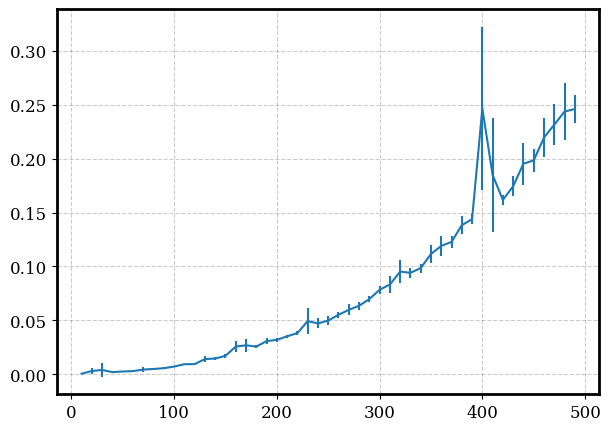

In [ ]:
from scipy.optimize import curve_fit
def lin(x,a):
    return x*a
def quad(x,a,b):
    return a*c+b*x**2
def cube(x,a,b,c):
    return a*x+b*x**2+c*x**3
cubic_fit_large_cov=curve_fit(cube,n,large_cov_times[:,0],sigma=large_cov_times[:,1])[0]
linear_fit_large_cov=curve_fit(lin,n,large_cov_times[:,0],sigma=large_cov_times[:,1])[0]
quadratic_fit_large_cov=curve_fit(quad,n,large_cov_times[:,0],sigma=large_cov_times[:,1])[0]
fix,ax=plt.subplots()
ax.errorbar(x=N,y=large_cov_times[:,0],yerr=large_cov_times[:,1],label='Large Cov')
x=np.linspace(10,5000,1000)
ax.plot(x,x*linear_fit_large_cov[0],linestyle='--',label='linear fit')
ax.plot(x,x*quadratic_fit_large_cov[0]+x**2*quadratic_fit_large_cov[1],linestyle='--',label='quadratic fit')
ax.plot(x,x*cubic_fit_large_cov[0]+x**2*cubic_fit_large_cov[1]+x**3*cubic_fit_large_cov[2],linestyle='--',label='cubic fit')

This scales poorly with n. Infact it scales as $O(n^3)$ as you can see in the fit.